In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

## Read Data

In [2]:
df = pd.read_excel('DS_Assignment.xlsx')
print(df.shape)
df.sample(10)

(45000, 112)


,userID,Contact_ind,Customer_status,ActiveSinceDays,num_AcD_m0,num_AcD_m1,r_AcD_m0_m12,r_AcD_m0_m123,daystofirstload,dayssincelastload,...,InAllRev_m1,InAllRev_m2,r_InAllRev_m0_m1,r_InAllRev_m0_m2,tot_InAllRev_3m,OgAllRev_m0,OgAllRev_m1,OgAllRev_m2,tot_OgAllRev_3m,targetid
13762,18763.0,1.0,3.0,1055.0,4.0,8.0,61.538462,75.000000,73.0,144.0,...,0.0,449.00,0.000000,0.000000,449.00,653.00,787.00,788.00,2228.00,0.0
23341,28342.0,1.0,3.0,593.0,1.0,2.0,40.000000,42.857143,0.0,95.0,...,100.0,0.00,891.089109,90000.000000,1000.00,1154.01,0.00,110.21,1264.22,0.0
23160,28161.0,1.0,3.0,107.0,1.0,5.0,25.000000,37.500000,12.0,119.0,...,500.0,0.00,0.000000,0.000000,500.00,19.00,415.00,857.00,1291.00,0.0
36429,41430.0,1.0,3.0,477.0,4.0,5.0,80.000000,100.000000,0.0,70.0,...,1792.0,1106.00,75.348578,122.041554,4249.00,1368.00,2562.00,1432.00,5362.00,1.0
15168,20169.0,1.0,4.0,194.0,3.0,2.0,150.000000,180.000000,5.0,169.0,...,0.0,0.00,0.000000,0.000000,0.00,879.00,1198.00,1500.00,3577.00,0.0
27597,32598.0,1.0,3.0,208.0,3.0,0.0,300.000000,180.000000,0.0,149.0,...,0.0,456.00,0.000000,0.000000,456.00,1018.00,0.00,458.00,1476.00,0.0
3417,8418.0,0.0,2.0,105.0,1.0,3.0,40.000000,60.000000,28.0,101.0,...,5000.0,10.00,0.000000,0.000000,5010.00,398.00,1729.00,10.00,2137.00,0.0
8655,13656.0,1.0,3.0,230.0,3.0,4.0,50.000000,47.368421,5.0,11.0,...,2188.0,49.17,31.978072,1395.256129,2937.17,773.00,2167.00,3768.00,6708.00,0.0
43812,48813.0,1.0,3.0,713.0,19.0,20.0,80.851064,80.281690,8.0,3.0,...,4660.0,6759.00,57.069298,39.349112,14079.00,3321.00,4339.00,6803.00,14463.00,0.0
12283,17284.0,1.0,3.0,598.0,16.0,14.0,118.518518,126.315789,0.0,31.0,...,33944.0,10508.00,139.784946,451.517747,91902.00,46447.53,30915.35,11125.31,88488.19,0.0


## EDA

In [3]:
# check if any column is interepreted as object, it looks like everything is numerical
try :
    object_cols = df.describe(include=object)
except Exception as e :
    print("No object types detected")

No object types detected


### check class imbalance

In [4]:
# There is class imblanace with 75 - 25 % ratio between churn and not churn
df.targetid.value_counts()

0.0    35833
1.0     9167
Name: targetid, dtype: int64

### Do some basic sanity checks

#### Check null values
- six columns have null values
- Some cells with values 999 or negative number might be missing values

In [5]:
df.isna().sum().sort_values(ascending=False)[:10]

r_avg_max_rechX_m2    12672
r_avg_max_rtlX_m2     11418
r_avg_max_rtlX_m1     11162
r_avg_max_rechX_m1    10519
r_avg_max_rtlX_m0      9805
r_avg_max_rechX_m0     6199
tot_billX_amt_m012        0
billX_amt_m2              0
billX_amt_m1              0
billX_amt_m0              0
dtype: int64

#### check for duplicate values 

In [6]:
duplicate = df[df.duplicated()]
duplicate

,userID,Contact_ind,Customer_status,ActiveSinceDays,num_AcD_m0,num_AcD_m1,r_AcD_m0_m12,r_AcD_m0_m123,daystofirstload,dayssincelastload,...,InAllRev_m1,InAllRev_m2,r_InAllRev_m0_m1,r_InAllRev_m0_m2,tot_InAllRev_3m,OgAllRev_m0,OgAllRev_m1,OgAllRev_m2,tot_OgAllRev_3m,targetid


In [7]:
#check for duplicate userId rows
duplicate = df['userID'][df['userID'].duplicated()]
duplicate

Series([], Name: userID, dtype: float64)

## Data Preparation

In [8]:
# Predictor variables are separated

## At later stage, we can treat columns with missing values to include in prediction
cols = ['userID',
        'r_avg_max_rechX_m2',
           'r_avg_max_rtlX_m2',
           'r_avg_max_rtlX_m1',
           'r_avg_max_rechX_m1',
           'r_avg_max_rtlX_m0',
           'r_avg_max_rechX_m0',
        'targetid'
       ]
X = df.drop(columns = cols)
y = df.targetid

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36000, 104) (9000, 104) (36000,) (9000,)


In [10]:
standard_scaler = StandardScaler(with_mean=False)
standard_scaler.fit(X_train)

# scale training set
X_train = standard_scaler.transform(X_train)
# scale test set
X_test = standard_scaler.transform(X_test)

## Modeling

#### Define functions for plots

In [11]:
def plot_confusion_matrix(y_test, y_pred):
    '''
    plot confusion matrix for given actual and predicted values
    '''
    
    # get confusion matrix and display 
    (tn, fp, fn, tp) = confusion_matrix(y_test,y_pred).ravel()
    cm =np.array([[tp, fp],[fn, tn]])

    # display churn vs no churn matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn', 'No Churn'])
    disp.plot(xticks_rotation='vertical', colorbar=False, cmap='Greens')
    disp.ax_.set_xlabel("Actual")
    disp.ax_.set_ylabel("Predicted")
    disp.ax_.xaxis.set_label_position('top')
    plt.show()
    

def roc_train_test(fpr_ts, tpr_ts, fpr_tr, tpr_tr):
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    roc_auc_tr = auc(fpr_tr, tpr_tr)

    fig = plt.figure(figsize= (14,6))
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.plot(fpr_ts, tpr_ts, color='green', lw=1, label='Test ROC Curve (area = %0.3f)' % roc_auc_ts)
    plt.plot(fpr_tr, tpr_tr, color='red', lw=1, label='Train Set ROC Curve (area = %0.3f)' % roc_auc_tr)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right",prop={'size': 22})
    plt.show()

### Random Forest Classifier

In [12]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

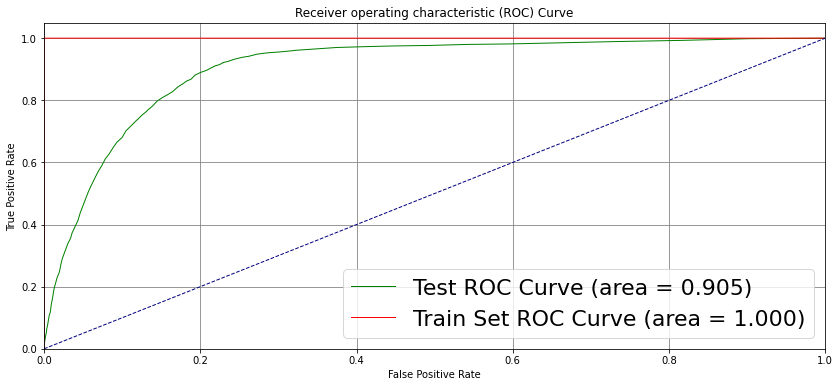

In [22]:
y_pred_prob = rf_clf.predict_proba(X_test).T[1]
fpr_test, tpr_test, threshold = roc_curve(y_test, y_pred_prob)
  
pred_prob_train = rf_clf.predict_proba(X_train).T[1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_prob_train)

roc_train_test(fpr_test, tpr_test,fpr_train, tpr_train)

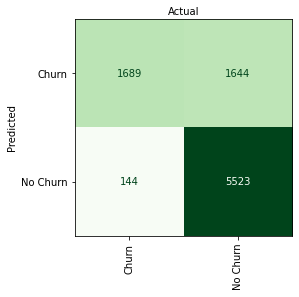

,Confusion Matrix
Precision,0.506751
Recall,0.921440
F1 Score,0.653891


In [14]:
# plot confusion matrix with threshold set
opt_threshold = round(threshold[np.argmax(tpr_test-fpr_test)], ndigits = 4)
y_pred = (rf_clf.predict_proba(X_test)[:,1] >= opt_threshold)
plot_confusion_matrix(y_test, y_pred)

# Get Precision Recall
pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, average='binary')[:3],
columns=['Confusion Matrix'],
index=['Precision', 'Recall', 'F1 Score'])

### Support Vector Machines

In [ ]:
%%time
svc_clf = SVC(kernel='rbf', probability=True)
svc_clf.fit(X_train, y_train)

In [ ]:
y_pred_prob = svc_clf.predict_proba(X_test).T[1]
fpr_test, tpr_test, threshold = roc_curve(y_test, y_pred_prob)
  
pred_prob_train = rf_clf.predict_proba(X_train).T[1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_prob_train)

roc_train_test(fpr_test, tpr_test,fpr_train, tpr_train)

In [ ]:
opt_threshold = round(threshold[np.argmax(tpr_test-fpr_test)], ndigits = 4)
y_pred = (svc_clf.predict_proba(X_test)[:,1] >= opt_threshold)
plot_confusion_matrix(y_test, y_pred)

# Get Precision Recall
pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, average='binary')[:3],
columns=['Confusion Matrix'],
index=['Precision', 'Recall', 'F1 Score'])

## Handle class imbalance

### Balanced Bagging Classifier

In [15]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=0)

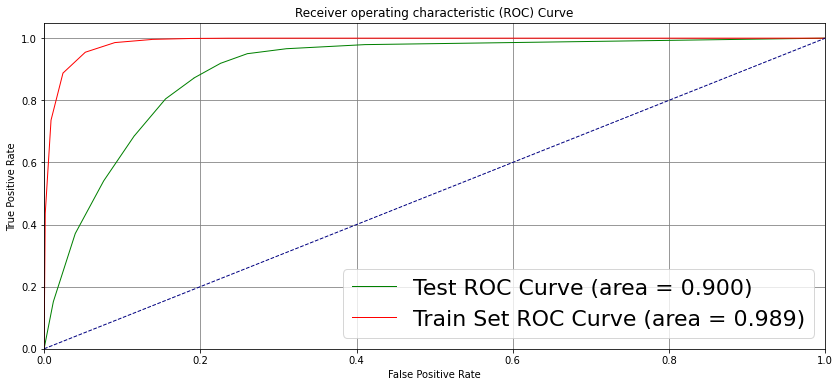

In [16]:
y_pred_prob = bbc.predict_proba(X_test).T[1]
fpr_test, tpr_test, threshold = roc_curve(y_test, y_pred_prob)
  
pred_prob_train = bbc.predict_proba(X_train).T[1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_prob_train)

pred = bbc.predict(X_test) 

roc_train_test(fpr_test, tpr_test,fpr_train, tpr_train)

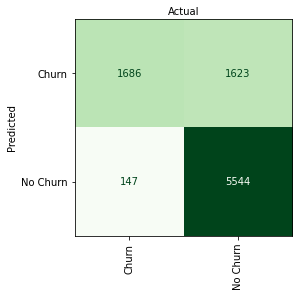

,Confusion Matrix
Precision,0.509519
Recall,0.919804
F1 Score,0.655776


In [17]:
# plot confusion matrix with threshold set
opt_threshold = round(threshold[np.argmax(tpr_test-fpr_test)], ndigits = 4)
y_pred = (bbc.predict_proba(X_test)[:,1] >= opt_threshold)
plot_confusion_matrix(y_test, y_pred)

# Get Precision Recall
pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, average='binary')[:3],
columns=['Confusion Matrix'],
index=['Precision', 'Recall', 'F1 Score'])

## Validation Set Prediction

In [19]:
df_valid = pd.read_excel('DS_Assignment_Validation_Set (1).xlsx')
df_valid.sample(5)

,userID,Contact_ind,Customer_status,ActiveSinceDays,num_AcD_m0,num_AcD_m1,r_AcD_m0_m12,r_AcD_m0_m123,daystofirstload,dayssincelastload,...,InAllRev_m0,InAllRev_m1,InAllRev_m2,r_InAllRev_m0_m1,r_InAllRev_m0_m2,tot_InAllRev_3m,OgAllRev_m0,OgAllRev_m1,OgAllRev_m2,tot_OgAllRev_3m
1790,1791.0,1.0,3.0,649.0,8.0,10.0,59.259259,61.538462,0.0,12.0,...,521.00,2164.67,3042.51,24.057220,17.118393,5728.18,1243.00,3238.78,3696.01,8177.79
4192,4193.0,1.0,3.0,261.0,4.0,4.0,133.333333,200.000000,0.0,71.0,...,1100.00,4500.00,2756.67,24.439014,39.888747,8356.67,1230.62,3181.19,2803.00,7214.81
3950,3951.0,1.0,3.0,1145.0,9.0,15.0,72.000000,58.695652,0.0,5.0,...,2726.32,2213.71,726.71,123.100541,374.643745,5666.74,2106.00,3116.00,4048.00,9270.00
2896,2897.0,1.0,3.0,1131.0,1.0,1.0,66.666667,60.000000,0.0,93.0,...,3960.00,0.00,108.00,396000.000000,3633.027523,4068.00,3941.99,0.00,107.24,4049.23
2809,2810.0,1.0,3.0,331.0,3.0,5.0,60.000000,60.000000,0.0,8.0,...,844.00,460.00,752.00,183.080260,112.084993,2056.00,844.00,460.00,752.00,2056.00


In [21]:
cols = ['userID',
        'r_avg_max_rechX_m2',
           'r_avg_max_rtlX_m2',
           'r_avg_max_rtlX_m1',
           'r_avg_max_rechX_m1',
           'r_avg_max_rtlX_m0',
           'r_avg_max_rechX_m0'
       ]
df_valid = df_valid.drop(columns = cols)
standard_scaler.fit(df_valid)

StandardScaler(with_mean=False)

In [31]:
df_valid.fillna(df.mean(), inplace=True)

In [32]:
y_valid_pred = (rf_clf.predict_proba(df_valid)[:,1] >= opt_threshold)
y_valid_pred

/Users/anmol/opt/anaconda3/envs/indus/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([ True,  True,  True, ...,  True,  True,  True])

In [39]:
list(df.dtypes.index)

['userID',
 'Contact_ind',
 'Customer_status',
 'ActiveSinceDays',
 'num_AcD_m0',
 'num_AcD_m1',
 'r_AcD_m0_m12',
 'r_AcD_m0_m123',
 'daystofirstload',
 'dayssincelastload',
 'tot_RevUo_m0',
 'tot_RevUo_m1',
 'tot_RevUo_m2',
 'r_tot_RevUo_m0_m1',
 'r_tot_RevUo_m1_m2',
 'r_tot_RevUo_m0_m12',
 'avg_RevUo_m0',
 'avg_RevUo_m1',
 'avg_RevUo_m2',
 'chg_RevUo_l0_1m',
 'chg_RevUo_l1_2m',
 'chg_RevUo_l2_3m',
 'tot_LdCnt_m0',
 'tot_LdCnt_m1',
 'tot_LdCnt_m2',
 'max_RevUo_m0',
 'max_RevUo_m1',
 'max_RevUo_m2',
 'r_avg_RevUo_m0_m1',
 'r_avg_RevUo_m1_m2',
 'avgdays_btw_loads_l6',
 'tot_failed_LdTxnCnt_3m',
 'r_failed_LdTxnCnt_m0_m12',
 'tot_rtlX_m0',
 'tot_rtlX_m1',
 'tot_rtlX_m2',
 'r_tot_rtlX_m0_m1',
 'r_tot_rtlX_m1_m2',
 'r_tot_rtlX_m0_m12',
 'avg_rtlX_m0',
 'avg_rtlX_m1',
 'avg_rtlX_m2',
 'max_rtlX_m0',
 'max_rtlX_m1',
 'max_rtlX_m2',
 'r_avg_max_rtlX_m0',
 'r_avg_max_rtlX_m1',
 'r_avg_max_rtlX_m2',
 'RtlTxns_cnt_m0',
 'RtlTxns_cnt_m1',
 'RtlTxns_cnt_m2',
 'r_RtlTxns_cnt_m0_m1',
 'r_RtlTxns_cnt